# Modelo de aprendizaje automático relacional

## Predicción de la popularidad de un artista en base a las colaboraciones que ha realizado

Son muchas las formas de triunfar en la música hoy en día. Es claro que conforme avanza la era digital, el talento musical y la búsqueda de una identidad musical está quedando en un segundo plano, al menos en la música más conocida. A su vez el marketing, principalmente en redes sociales está cobrando fuerza y es que uno de los mayores retos de los mánagers de los artistas emergentes es la llamada *viralidad*. 

En este ámbito entra una herramienta tan efectiva como son las colaboraciones con otros artistas. Pese a llevar existiendo desde prácticamente los inicios de la música, en la actualidad es una técnica casi perfecta para llevar a un artista a la fama. Asimismo, los artistas que ya cuentan con una gran repercusión suelen optar por colaborar con otros artistas con grandes números con el objetivo de retroalimentarse y juntar grandes volúmenes de públicos en un solo producto.

Dado este contexto, este proyecto tiene como objetivo analizar cómo siendo conocidas tan solo las colaboraciones entre artistas se puede llegar a predecir la popularidad. Lo haremos mediante un grafo que tiene como nodos los artistas, estando conectados estos nodos si los respectivos artistas han colaborado. Utilizando técnicas de modelado basadas en teoría de grafos obtendremos métricas de este grafo que nos permitirán, con herramientas de aprendizaje automático, dar un modelo de predicción de la popularidad.

En este primer notebook vamos a realizar un breve análisis exploratorio y construiremos el dataframe con el que llevaremos a cabo los distintos modelos.

### Carga de librerías y datos

In [45]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

In [46]:
edges = pd.read_csv("data/edges.csv")
nodes = pd.read_csv("data/nodes.csv")

In [47]:
nodes.head()

,spotify_id,name,followers,popularity,genres,chart_hits
0,48WvrUGoijadXXCsGocwM4,Byklubben,1738.0,24,"['nordic house', 'russelater']",['no (3)']
1,4lDiJcOJ2GLCK6p9q5BgfK,Kontra K,1999676.0,72,"['christlicher rap', 'german hip hop']","['at (44)', 'de (111)', 'lu (22)', 'ch (31)', ..."
2,652XIvIBNGg3C0KIGEJWit,Maxim,34596.0,36,[],['de (1)']
3,3dXC1YPbnQPsfHPVkm1ipj,Christopher Martin,249233.0,52,"['dancehall', 'lovers rock', 'modern reggae', ...","['at (1)', 'de (1)']"
4,74terC9ol9zMo8rfzhSOiG,Jakob Hellman,21193.0,39,"['classic swedish pop', 'norrbotten indie', 's...",['se (6)']


In [48]:
edges.shape

(300386, 2)

Como vemos, el número de aristas es muy elevado. Con la idea de trabajar con un dataset de un tamaño más reducido y sin perder la integridad de los datos, vamos a proceder de la siguiente forma:

Partimos de los 150 artistas más populares según la métrica dada por la API de Spotify. Posteriormente, tomamos los artistas que han colaborado con estos y tenemos en cuenta las colaboraciones entre estos artistas. De esta forma, restringimos el dataset a la red de los artistas más populares.

In [50]:
def mostPopular(nodes, edges, k):
    top_artists = nodes.nlargest(k, "popularity")
    top_artist_ids = set(top_artists["spotify_id"])
    
    collaborators = set(edges[edges["id_0"].isin(top_artist_ids)]["id_1"]).union(
        set(edges[edges["id_1"].isin(top_artist_ids)]["id_0"])
    )
    
    final_artist_ids = top_artist_ids.union(collaborators)
    filtered_edges = edges[
        (edges["id_0"].isin(final_artist_ids)) & (edges["id_1"].isin(final_artist_ids))
    ].reset_index(drop=True)
    
    connected_nodes = set(filtered_edges["id_0"]).union(set(filtered_edges["id_1"]))
    filtered_nodes = nodes[nodes["spotify_id"].isin(connected_nodes)].reset_index(drop=True).drop_duplicates(subset='spotify_id', keep='first')
    
    return filtered_nodes, filtered_edges

In [51]:
nd = pd.read_csv("data/nodes.csv")  
ed = pd.read_csv("data/edges.csv")
nodes, edges = mostPopular(nd, ed, 150)
nodes.sort_values('popularity', ascending = False).head()

,spotify_id,name,followers,popularity,genres,chart_hits
1258,4q3ewBCX7sLwd24euuV69X,Bad Bunny,55669387.0,100,"['reggaeton', 'trap latino']","['us (76)', 'gb (1)', 'ar (91)', 'au (2)', 'at..."
2122,3TVXtAsR1Inumwj472S9r4,Drake,66852536.0,95,"['canadian hip hop', 'canadian pop', 'hip hop'...","['us (190)', 'gb (163)', 'ar (18)', 'au (148)'..."
515,06HL4z0CvFAxyc27GXpf02,Taylor Swift,58554324.0,94,['pop'],"['us (136)', 'gb (115)', 'ar (24)', 'au (110)'..."
1577,1Xyo4u8uXC1ZmMpatF05PJ,The Weeknd,49387909.0,93,"['canadian contemporary r&b', 'canadian pop', ...","['us (81)', 'gb (74)', 'ar (23)', 'au (76)', '..."
1982,3Nrfpe0tUJi4K4DXYWgMUX,BTS,54532917.0,91,"['k-pop', 'k-pop boy group']","['us (55)', 'gb (32)', 'ar (30)', 'au (32)', '..."


In [52]:
nodes.shape, edges.shape 

((6410, 6), (40773, 2))

### Análisis exploratorio

Veamos el número de artistas que pertenecen a los distintos géneros que se mencionan en la variable `gender`.

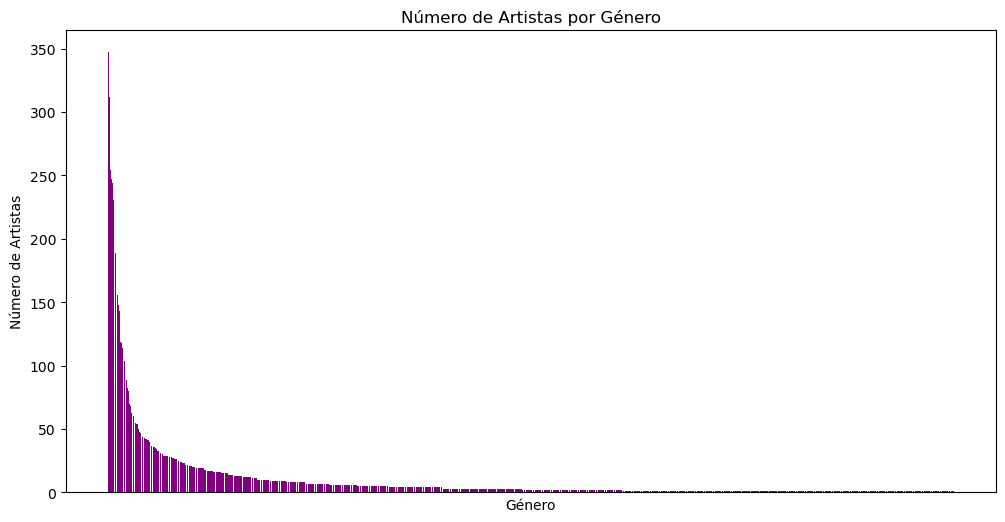

In [55]:
nodes["genres"] = nodes["genres"].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) else x)

genre_counts = {}
for genres in nodes["genres"]:
    for genre in genres:
        genre_counts[genre] = genre_counts.get(genre, 0) + 1

genre_df = pd.DataFrame(list(genre_counts.items()), columns=["Genre", "Artist Count"])
genre_df = genre_df.sort_values(by="Artist Count", ascending=False)

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(genre_df["Genre"], genre_df["Artist Count"], color="purple") 
plt.xticks([])
plt.xlabel("Género")
plt.ylabel("Número de Artistas")
plt.title("Número de Artistas por Género")
plt.show()

Como vemos, hay una enorme cantidad de géneros distintos considerados. Además es claro que hay una pequeña cantidad de ellos que son interpretadas por un gran número de artistas. Esta es la llamada distribución de grado en ley de potencia, muy usual en sistemas complejos.

Veamos los 30 géneros con más artistas asociados.

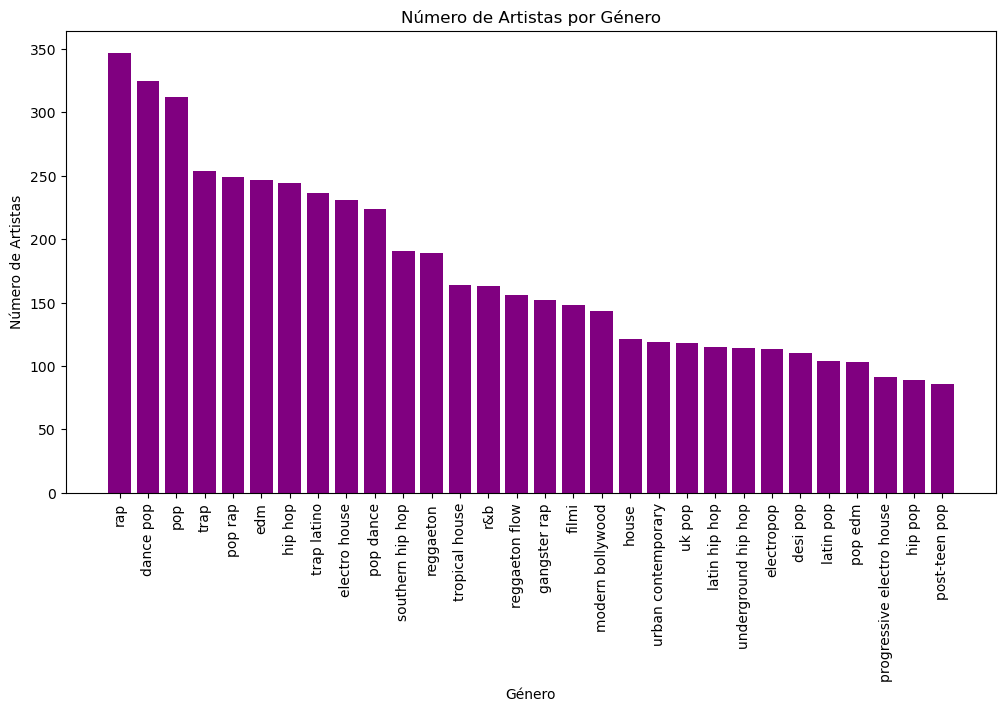

In [58]:
plt.figure(figsize=(12, 6))
plt.bar(genre_df["Genre"][:30], genre_df["Artist Count"][:30], color="purple") 
plt.xticks(rotation = 90)
plt.xlabel("Género")
plt.ylabel("Número de Artistas")
plt.title("Número de Artistas por Género")
plt.show()

Destacan claramente los géneros urbanos.

Veamos ahora la distribución de la popularidad de los artistas.

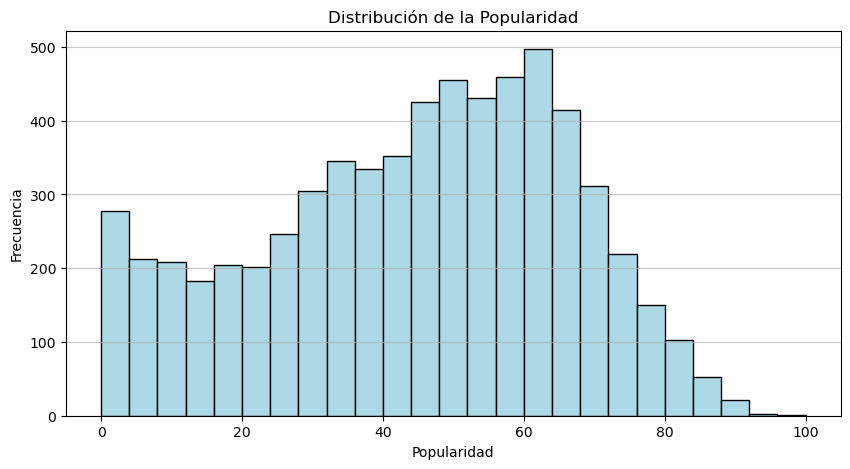

In [61]:
plt.figure(figsize=(10, 5))
plt.hist(nodes["popularity"], bins=25, color='lightblue', edgecolor='black')
plt.xlabel("Popularidad")
plt.ylabel("Frecuencia")
plt.title("Distribución de la Popularidad")
plt.grid(axis='y', alpha=0.75)
plt.show()

Para la muestra seleccionada hay una mayor cantidad de artistas con una popularidad media/alta, una cantidad considerable de artistas que tienen este campo bastante reducido y por último un pequeño nicho de artistas que gozan de una gran popularidad. Recordemos que nuestra muestra fue seleccionada a partir de los artistas más populares, luego se espera que a medida que la muestra se va incrementando el número de artistas con una popularidad baja siga aumentando, llegando así también a una distribución de grado en ley de potencia.

Veamos el número de colaboraciones que han hecho los artistas frente a su popularidad

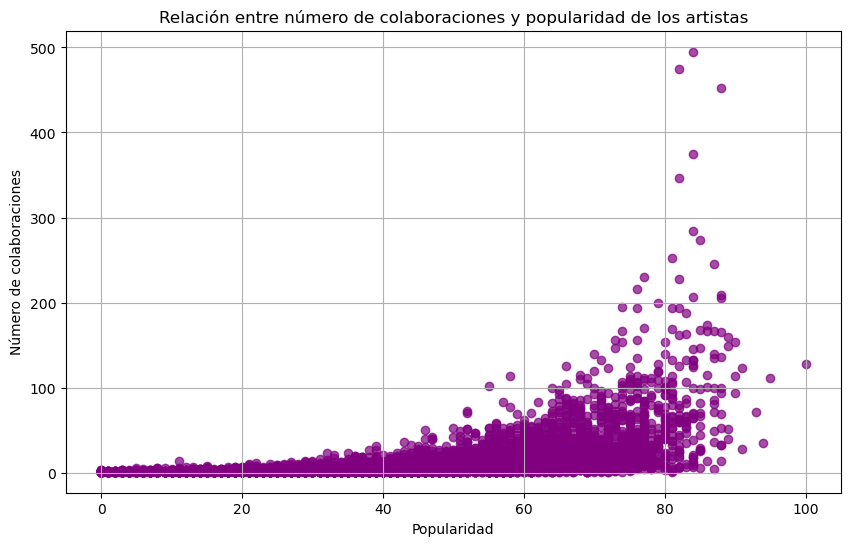

In [64]:
collab_counts = pd.concat([edges['id_0'], edges['id_1']]).value_counts().reset_index()
collab_counts.columns = ['spotify_id', 'num_colaboraciones']

nodes_with_collabs = pd.merge(nodes, collab_counts, on='spotify_id', how='left').fillna(0)

plt.figure(figsize=(10, 6))
plt.scatter(nodes_with_collabs['popularity'], nodes_with_collabs['num_colaboraciones'], alpha=0.7, color = 'purple')
plt.xlabel('Popularidad')
plt.ylabel('Número de colaboraciones')
plt.title('Relación entre número de colaboraciones y popularidad de los artistas')
plt.grid(True)
plt.show()

Vemos como aparentemente un aumento en el número de colaboraciones implica un aumento de la popularidad.

### Planteamiento del modelo

El objetivo del modelo de aprendizaje automático relacional va a ser predecir si un artista es popular en función de las colaboraciones que ha desempeñado este. Consideraremos una nueva variable `popularity_level` que va a tomar los valores en función de la variable original `popularity`:
* 0-50: 0 (No Popular)
* 50-100: 1 (Popular)

In [68]:
bins = [0,50,100]
labels = [0,1]

nodes['popularity_level'] = pd.cut(nodes['popularity'], bins=bins, labels=labels, include_lowest=True)
nodes.head()

,spotify_id,name,followers,popularity,genres,chart_hits,popularity_level
0,2NUz5P42WqkxilbI8ocN76,Vybz Kartel,1026598.0,63,"[dancehall, jamaican dancehall, reggae fusion]","['cr (3)', 'pa (1)']",1
1,6M2wZ9GZgrQXHCFfjv46we,Dua Lipa,36163788.0,88,"[dance pop, pop, uk pop]","['us (17)', 'gb (25)', 'ar (18)', 'au (20)', '...",1
2,5Matrg5du62bXwer29cU5T,Benny The Butcher,266547.0,64,"[boom bap, buffalo hip hop, hip hop, rap, upst...","['us (1)', 'ca (1)', 'za (1)']",1
3,7jZMxhsB8djyIbYmoiJSTs,Kiana Ledé,1351452.0,64,"[chill r&b, dance pop, pop, pop r&b, r&b, rap,...","['cy (1)', 'id (1)', 'lt (1)', 'mt (1)', 'no (...",1
4,6pUYaWjHnY2HdN6RC6ELml,Total Ape,3330.0,34,[],['se (1)'],0


In [69]:
nodes['popularity_level'].value_counts()

popularity_level
0    3632
1    2778
Name: count, dtype: int64

Veamos la representación de un subgrafo distinguiendo los niveles de popularidad de los artistas.

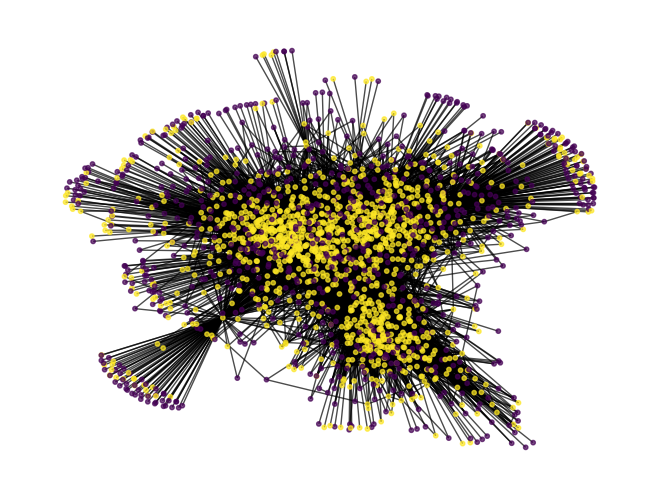

In [71]:
g = nx.from_pandas_edgelist(edges, source="id_0", target="id_1")
sub_nodes, sub_edges = mostPopular(nodes, edges, 30)
subg = nx.from_pandas_edgelist(sub_edges, source="id_0", target="id_1")
nx.draw(subg,node_size=10, alpha = 0.7, node_color = sub_nodes['popularity_level'])

Analicemos la distribución de grados del grafo.

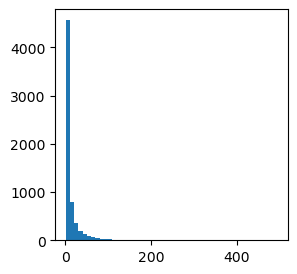

In [73]:
degrees = [g.degree(n) for n in g.nodes()]
plt.figure(figsize = (3,3)) #histograma de la distribucion del grafo
plt.hist(degrees,50)
plt.show()

De nuevo aparece la distribución de grado en ley de potencia. En nuestra muestra de los artistas más populares se presencia un pequeño número de artitas que han realizado un gran número de colaboraciones, mientras que la gran mayoría no han llegado a realizar muchas colaboraciones con los artistas más populares. Esto puede ser debido a que los artistas más conocidos mundialmente tienden a juntarse con otros artistas que también tienen una gran fama, pues esa es normalmente la intención de las discográficas.

Vamos a crear un `dataframe` con métricas usuales en Teoría de Grafos (de centralidad, de grado,...) y la variable objetivo.

In [76]:
df = pd.DataFrame(nodes['popularity_level'].astype(int))
df['degree'] = nx.degree_centrality(g).values() 
df['betweennes'] = nx.betweenness_centrality(g).values()
df['closeness'] = nx.closeness_centrality(g).values()
df['eigenvector'] = nx.eigenvector_centrality(g).values()
df['clustering'] = nx.clustering(g).values()
df.head()

,popularity_level,degree,betweennes,closeness,eigenvector,clustering
0,1,0.002809,0.000086,0.318572,0.005886,0.111111
1,1,0.012638,0.002468,0.370180,0.043645,0.122222
2,1,0.019348,0.016555,0.339355,0.027648,0.063729
3,1,0.005149,0.001371,0.304206,0.011840,0.193182
4,0,0.001872,0.000031,0.310888,0.004246,0.181818


In [77]:
df['popularity_level'] = nodes['popularity_level'].astype(int)

In [78]:
df.to_csv('data/out.csv', index = False)